# Mise en place d'un moteur de recherche

In [ ]:
# Exercice 3 : Mise en place d'un moteur de recherche
# M2 MIASHS : projet Network Analysis for Information Retrieval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import time
from tqdm import tqdm

# Scikit-learn pour le traitement de texte et les métriques
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize

# NLTK pour le stemming et stopwords
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configuration pour un meilleur affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# 1. Classe principale du moteur de recherche
class SearchEngine:
    """
    Moteur de recherche pour les articles scientifiques.
    """
    
    def __init__(self, 
                 use_tfidf=True,           # TF-IDF (True) ou TF (False)
                 min_df=5,                 # Fréquence min des termes
                 max_df=0.95,              # Fréquence max des termes
                 use_stemming=True,        # Stemming (True) ou Lemmatisation (False)
                 remove_stopwords=True,    # Suppression des mots-outils
                 similarity_metric='cosine', # 'cosine' ou 'euclidean'
                 max_vocab_size=None):      # Limite max du vocabulaire
        """
        Initialise le moteur de recherche avec une configuration spécifique.
        
        Args:
            use_tfidf (bool): Utiliser TF-IDF (True) ou TF (False)
            min_df (int or float): Fréquence minimale des termes
            max_df (float): Fréquence maximale des termes
            use_stemming (bool): Utiliser le stemming (True) ou la lemmatisation (False)
            remove_stopwords (bool): Supprimer les mots-outils
            similarity_metric (str): Métrique de similarité ('cosine' ou 'euclidean')
            max_vocab_size (int): Limite maximale du vocabulaire (None = pas de limite)
        """
        self.use_tfidf = use_tfidf
        self.min_df = min_df
        self.max_df = max_df
        self.use_stemming = use_stemming
        self.remove_stopwords = remove_stopwords
        self.similarity_metric = similarity_metric
        self.max_vocab_size = max_vocab_size
        
        # Initialisation des composants
        self.vectorizer = None
        self.document_term_matrix = None
        self.documents = None
        self.feature_names = None
        self.configuration = None
        self.df = None
        
        # Créer une description de la configuration
        self._create_configuration_description()
    
    def _create_configuration_description(self):
        """
        Crée une description de la configuration pour affichage.
        """
        ponderation = "TF-IDF" if self.use_tfidf else "TF"
        normalisation = "Stemming" if self.use_stemming else "Lemmatisation"
        stopwords_desc = "sans stopwords" if self.remove_stopwords else "avec stopwords"
        vocab_size = f"{self.max_vocab_size} mots" if self.max_vocab_size else "Pas de limite"
        
        self.configuration = (f"Configuration: {ponderation}, {normalisation}, {stopwords_desc}, "
                             f"min_df={self.min_df}, max_df={self.max_df}, "
                             f"similarité={self.similarity_metric}, vocabulaire={vocab_size}")
    
    def _create_preprocessor(self):
        """
        Crée une fonction de prétraitement de texte.
        
        Returns:
            function: Fonction de prétraitement
        """
        def preprocessor(text):
            # Conversion en minuscules
            text = text.lower()
            
            # Suppression des chiffres et de la ponctuation
            text = re.sub(r'\d+', '', text)
            text = re.sub(r'[^\w\s]', ' ', text)
            
            # Suppression des espaces multiples
            text = re.sub(r'\s+', ' ', text).strip()
            
            return text
        
        return preprocessor
    
    def _create_tokenizer(self):
        """
        Crée une fonction de tokenisation avec stemming ou lemmatisation.
        
        Returns:
            function: Fonction de tokenisation
        """
        if self.use_stemming:
            stemmer = PorterStemmer()
            
            def tokenizer(text):
                words = word_tokenize(text)
                return [stemmer.stem(word) for word in words]
        else:
            lemmatizer = WordNetLemmatizer()
            
            def tokenizer(text):
                words = word_tokenize(text)
                return [lemmatizer.lemmatize(word) for word in words]
        
        return tokenizer
    
    def _create_vectorizer(self):
        """
        Crée un vectoriseur adapté à la configuration choisie.
        
        Returns:
            CountVectorizer or TfidfVectorizer: Vectoriseur configuré
        """
        # Récupération des stop words
        stop_words = None
        if self.remove_stopwords:
            stop_words = stopwords.words('english')
            # Ajout de stop words spécifiques au domaine scientifique
            scientific_stop_words = [
                'doi', 'fig', 'figure', 'et', 'al', 'paper', 'study', 'research',
                'method', 'results', 'analysis', 'data', 'proposed', 'approach',
                'using', 'based', 'used', 'show', 'shown', 'table', 'section'
            ]
            stop_words.extend(scientific_stop_words)
        
        # Paramètres communs
        common_params = {
            'preprocessor': self._create_preprocessor(),
            'tokenizer': self._create_tokenizer(),
            'stop_words': stop_words,
            'min_df': self.min_df,
            'max_df': self.max_df,
            'max_features': self.max_vocab_size,
            'ngram_range': (1, 1)  # Unigrammes uniquement
        }
        
        # Création du vectoriseur approprié
        if self.use_tfidf:
            return TfidfVectorizer(**common_params)
        else:
            return CountVectorizer(**common_params)
    
    def fit(self, df, text_column='combined_text'):
        """
        Entraîne le moteur de recherche sur un DataFrame d'articles.
        
        Args:
            df (pandas.DataFrame): DataFrame contenant les articles
            text_column (str): Nom de la colonne contenant le texte à indexer
            
        Returns:
            self: Pour chaînage de méthodes
        """
        self.df = df.copy()
        
        # Vérifier si la colonne de texte combiné existe
        if text_column not in self.df.columns:
            print(f"Création de la colonne {text_column}...")
            # Combiner le titre et le résumé
            self.df[text_column] = self.df.apply(
                lambda row: f"{row['title']} {row['abstract'] if pd.notna(row['abstract']) else ''}",
                axis=1
            )
        
        # Création du vectoriseur
        self.vectorizer = self._create_vectorizer()
        
        # Transformation des documents
        print(f"Vectorisation des documents avec {self.configuration}...")
        self.document_term_matrix = self.vectorizer.fit_transform(self.df[text_column])
        
        # Extraction des noms de features
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        # Affichage des informations sur la matrice
        print(f"Matrice documents-termes: {self.document_term_matrix.shape[0]} documents × {self.document_term_matrix.shape[1]} termes")
        print(f"Densité de la matrice: {self.document_term_matrix.nnz / (self.document_term_matrix.shape[0] * self.document_term_matrix.shape[1]):.4f}")
        
        return self
    
    def search(self, query, top_k=10):
        """
        Recherche les documents les plus pertinents pour une requête donnée.
        
        Args:
            query (str): Requête de recherche
            top_k (int): Nombre de résultats à retourner
            
        Returns:
            pandas.DataFrame: DataFrame contenant les documents les plus pertinents
        """
        if self.vectorizer is None or self.document_term_matrix is None:
            raise ValueError("Le moteur de recherche n'a pas été entraîné. Appelez d'abord fit().")
        
        # Transformation de la requête en vecteur
        query_vector = self.vectorizer.transform([query])
        
        # Calcul des similarités
        start_time = time.time()
        
        if self.similarity_metric == 'cosine':
            # Pour la similarité cosinus, plus le score est élevé, plus les documents sont similaires
            similarities = cosine_similarity(query_vector, self.document_term_matrix).flatten()
            # Tri par similarité décroissante
            top_indices = similarities.argsort()[::-1][:top_k]
        else:  # euclidean
            # Pour la distance euclidienne, plus le score est bas, plus les documents sont similaires
            distances = euclidean_distances(query_vector, self.document_term_matrix).flatten()
            # Tri par distance croissante
            top_indices = distances.argsort()[:top_k]
            # Conversion des distances en scores (1 / (1 + distance))
            similarities = 1 / (1 + distances)
        
        search_time = time.time() - start_time
        
        # Création d'un DataFrame avec les résultats
        results = []
        for i, idx in enumerate(top_indices):
            score = similarities[idx]
            results.append({
                'rank': i + 1,
                'score': score,
                'id': self.df.iloc[idx]['id'],
                'title': self.df.iloc[idx]['title'],
                'abstract': self.df.iloc[idx].get('abstract', ''),
                'authors': self.df.iloc[idx].get('author_names', ''),
                'venue': self.df.iloc[idx].get('venue', ''),
                'year': self.df.iloc[idx].get('year', '')
            })
        
        results_df = pd.DataFrame(results)
        
        print(f"Recherche effectuée en {search_time:.3f} secondes")
        print(f"Nombre de résultats: {len(results_df)}")
        
        return results_df
    
    def explain_search_result(self, query, doc_idx, top_n_terms=10):
        """
        Explique pourquoi un document a été retourné pour une requête donnée.
        
        Args:
            query (str): Requête de recherche
            doc_idx (int): Indice du document dans le DataFrame original
            top_n_terms (int): Nombre de termes les plus importants à afficher
            
        Returns:
            dict: Dictionnaire contenant les termes les plus importants et leurs poids
        """
        if self.vectorizer is None or self.document_term_matrix is None:
            raise ValueError("Le moteur de recherche n'a pas été entraîné. Appelez d'abord fit().")
        
        # Transformation de la requête en vecteur
        query_vector = self.vectorizer.transform([query]).toarray().flatten()
        
        # Récupération du vecteur du document
        doc_vector = self.document_term_matrix[doc_idx].toarray().flatten()
        
        # Calcul des contributions de chaque terme
        contributions = query_vector * doc_vector
        
        # Récupération des indices des termes avec les plus grandes contributions
        top_term_indices = contributions.argsort()[::-1][:top_n_terms]
        
        # Création d'un dictionnaire {terme: contribution}
        term_contributions = {}
        for idx in top_term_indices:
            if contributions[idx] > 0:  # Ne garder que les termes qui contribuent positivement
                term = self.feature_names[idx]
                term_contributions[term] = {
                    'contribution': contributions[idx],
                    'query_weight': query_vector[idx],
                    'doc_weight': doc_vector[idx]
                }
        
        return term_contributions

# 2. Fonctions de support pour la préparation des données et les tests
def prepare_combined_text(df):
    """
    Prépare une colonne de texte combiné (titre + résumé) pour l'indexation.
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les articles
        
    Returns:
        pandas.DataFrame: DataFrame avec la colonne 'combined_text' ajoutée
    """
    df = df.copy()
    df['combined_text'] = df.apply(
        lambda row: f"{row['title']} {row['abstract'] if pd.notna(row['abstract']) else ''}",
        axis=1
    )
    return df

def create_search_engine_variants():
    """
    Crée plusieurs variantes du moteur de recherche pour comparaison.
    
    Returns:
        list: Liste de moteurs de recherche avec différentes configurations
    """
    variants = []
    
    # 1. Variation sur le schéma de pondération (TF vs TF-IDF)
    variants.append(SearchEngine(use_tfidf=True, min_df=5, max_df=0.95))   # TF-IDF
    variants.append(SearchEngine(use_tfidf=False, min_df=5, max_df=0.95))  # TF
    
    # 2. Variation sur la taille du vocabulaire
    variants.append(SearchEngine(use_tfidf=True, min_df=5, max_df=0.95, max_vocab_size=500))   # 500 mots
    variants.append(SearchEngine(use_tfidf=True, min_df=5, max_df=0.95, max_vocab_size=5000))  # 5000 mots
    
    # 3. Variation sur les stopwords
    variants.append(SearchEngine(use_tfidf=True, min_df=5, max_df=0.95, remove_stopwords=False))  # Avec stopwords
    
    # 4. Variation sur la mesure de similarité
    variants.append(SearchEngine(use_tfidf=True, min_df=5, max_df=0.95, similarity_metric='euclidean'))  # Distance euclidienne
    
    return variants

def compare_search_results(engines, query, top_k=5):
    """
    Compare les résultats de recherche entre différentes configurations du moteur.
    
    Args:
        engines (list): Liste des moteurs de recherche à comparer
        query (str): Requête de recherche
        top_k (int): Nombre de résultats à afficher pour chaque moteur
        
    Returns:
        dict: Dictionnaire contenant les résultats de chaque moteur
    """
    results = {}
    
    for engine in engines:
        print(f"\n=== {engine.configuration} ===")
        engine_results = engine.search(query, top_k=top_k)
        results[engine.configuration] = engine_results
        
        # Affichage des résultats
        print("\nTop résultats:")
        for i, row in engine_results.iterrows():
            print(f"{row['rank']}. [{row['score']:.4f}] {row['title']}")
            print(f"   Auteurs: {row['authors']}")
            print(f"   Venue: {row['venue']} ({row['year']})")
            print(f"   Abstract: {row['abstract'][:150]}...")
        
        # Explication du premier résultat
        if len(engine_results) > 0:
            print("\nExplication du premier résultat:")
            doc_idx = engine_results.iloc[0]['rank'] - 1  # Indice de base 0
            explanation = engine.explain_search_result(query, doc_idx)
            for term, details in explanation.items():
                print(f"- '{term}': contribution = {details['contribution']:.4f}")
    
    return results

def visualize_term_importance(engines, query, top_k=10):
    """
    Visualise l'importance des termes de la requête dans les différentes configurations.
    
    Args:
        engines (list): Liste des moteurs de recherche à comparer
        query (str): Requête de recherche
        top_k (int): Nombre de termes importants à afficher
    """
    # Préparation des données pour la visualisation
    all_terms = set()
    term_importances = {}
    
    for engine in engines:
        # Transformation de la requête
        query_vector = engine.vectorizer.transform([query])
        
        # Récupération des poids des termes
        feature_names = engine.vectorizer.get_feature_names_out()
        term_weights = {}
        
        # Pour chaque terme de la requête qui existe dans le vocabulaire
        for term in query.lower().split():
            # Recherche de correspondances (en tenant compte du stemming/lemmatisation)
            matched_terms = [f for f in feature_names if term in f]
            
            for matched_term in matched_terms:
                # Trouver l'indice du terme dans le vocabulaire
                term_idx = list(feature_names).index(matched_term)
                # Récupérer son poids dans le vecteur de requête
                term_weights[matched_term] = query_vector[0, term_idx]
                all_terms.add(matched_term)
        
        # Tri et sélection des top termes
        sorted_terms = sorted(term_weights.items(), key=lambda x: x[1], reverse=True)[:top_k]
        term_importances[engine.configuration] = dict(sorted_terms)
    
    # Création d'un DataFrame pour la visualisation
    terms = list(all_terms)
    engine_configs = [engine.configuration.split(':')[0] for engine in engines]
    data = []
    
    for term in terms:
        row = {'term': term}
        for i, engine in enumerate(engines):
            config = engine.configuration
            row[f'config_{i}'] = term_importances.get(config, {}).get(term, 0)
        data.append(row)
    
    df_viz = pd.DataFrame(data)
    
    # Visualisation
    plt.figure(figsize=(14, 8))
    for i in range(len(engines)):
        plt.subplot(2, 3, i+1)
        config_df = df_viz.sort_values(f'config_{i}', ascending=False).head(top_k)
        sns.barplot(x=f'config_{i}', y='term', data=config_df)
        plt.title(f"Configuration {i+1}")
        plt.xlabel("Importance")
        plt.ylabel("Terme")
    
    plt.tight_layout()
    plt.show()

# 3. Interface utilisateur pour tester le moteur de recherche
def search_interface(engine, max_results=10):
    """
    Interface utilisateur simple pour tester le moteur de recherche.
    
    Args:
        engine (SearchEngine): Moteur de recherche à utiliser
        max_results (int): Nombre maximum de résultats à afficher
    """
    print("\n===== MOTEUR DE RECHERCHE D'ARTICLES SCIENTIFIQUES =====")
    print(engine.configuration)
    print("\nTaille du vocabulaire:", len(engine.feature_names))
    print("Nombre total d'articles:", engine.document_term_matrix.shape[0])
    print("\nEntrez votre requête (ou 'q' pour quitter):")
    
    while True:
        query = input("\n> ")
        
        if query.lower() == 'q':
            break
        
        if not query.strip():
            continue
        
        # Recherche
        results = engine.search(query, top_k=max_results)
        
        # Affichage des résultats
        print(f"\n{len(results)} résultats trouvés pour '{query}':")
        for i, row in results.iterrows():
            print(f"\n{row['rank']}. [{row['score']:.4f}] {row['title']}")
            print(f"   Auteurs: {row['authors']}")
            print(f"   Venue: {row['venue']} ({row['year']})")
            if pd.notna(row['abstract']) and row['abstract']:
                print(f"   Abstract: {row['abstract'][:150]}...")


## Chargement des données

In [3]:
# 1. Chargement des données
input_file = "articles_processed.pkl"
try:
    df = pd.read_pickle(input_file)
    print(f"Données chargées avec succès. Shape: {df.shape}")
except Exception as e:
    print(f"Erreur lors du chargement des données: {e}")

Données chargées avec succès. Shape: (79007, 11)


## Préparation des données

In [4]:
# 2. Préparation des données
df = prepare_combined_text(df)

## Création et entraînement du moteur de recherche principal

In [5]:
# 3. Création et entraînement du moteur de recherche principal
# Vous pouvez choisir la configuration qui vous convient
engine = SearchEngine(
    use_tfidf=True,           # TF-IDF (True) ou TF (False)
    min_df=5,                 # Fréquence min des termes (5 = apparaît dans au moins 5 documents)
    max_df=0.95,              # Fréquence max des termes (0.95 = apparaît dans max 95% des documents)
    use_stemming=True,        # Stemming (True) ou Lemmatisation (False)
    remove_stopwords=True,    # Suppression des mots-outils
    similarity_metric='cosine' # 'cosine' ou 'euclidean'
)
engine.fit(df)

Vectorisation des documents avec Configuration: TF-IDF, Stemming, sans stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=Pas de limite...


c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'analysi', 'ani', 'base', 'becaus', 'befor', 'doe', 'dure', 'figur', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'propos', 'result', 'studi', 'tabl', 'themselv', 'thi', 'use', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


Matrice documents-termes: 79007 documents × 13763 termes
Densité de la matrice: 0.0030


## Recherche avec une requête d'exemple

In [6]:
# 4. Recherche avec une requête d'exemple
example_query = "deep learning neural networks"
results = engine.search(example_query, top_k=10)
print("\nRésultats pour la requête:", example_query)
display(results[['rank', 'score', 'title', 'authors', 'venue']])

Recherche effectuée en 0.098 secondes
Nombre de résultats: 10

Résultats pour la requête: deep learning neural networks


,rank,score,title,authors,venue
0,1,0.733455,A tool for Emergency Detection with Deep Learn...,"Emanuele Cipolla, Riccardo Rizzo, Dario Stabil...",
1,2,0.692924,Face Deidentification with Generative Deep Neu...,"Blaž Meden, Refik Mallı, Sebastjan Fabijan, Ha...",Iet Signal Processing
2,3,0.677886,Efficient Model Averaging for Deep Neural Netw...,"Michael Opitz, Horst Possegger, Horst Bischof",asian conference on computer vision
3,4,0.669512,Classification regions of deep neural networks,"Alhussein Fawzi, Seyed-Mohsen Moosavi-Dezfooli...",
4,5,0.649344,Learning to Optimize: Training Deep Neural Net...,"Haoran Sun, Xiangyi Chen, Qingjiang Shi, Mingy...",
5,6,0.640012,Nonlinear system modeling with deep neural net...,"Erick de la Rosa, Wen Yu, Xiaoou Li","systems, man and cybernetics"
6,7,0.633609,DEBC Detection with Deep Learning.,"Ian E. Nordeng, Ahmad Hasan, Doug Olsen, Jerem...",
7,8,0.633357,Subregular Complexity and Deep Learning,"Enes Avcu, Chihiro Shibata, Jeffrey Heinz",
8,9,0.630997,Word Representation Using A Deep Neural Network,Yunpeng Li,conference of the centre for advanced studies ...
9,10,0.614282,Toolkits and Libraries for Deep Learning,"Bradley J. Erickson, Panagiotis Korfiatis, Zey...",Journal of Digital Imaging


## Essai avec d'autres requêtes

In [7]:
# 5. Essai avec d'autres requêtes
# Testez avec vos propres requêtes
test_queries = [
    "machine learning algorithms",
    "natural language processing",
    "computer vision image recognition"
]

for query in test_queries:
    print(f"\n\n=== REQUÊTE: {query} ===")
    results = engine.search(query, top_k=5)
    display(results[['rank', 'score', 'title', 'venue']])




=== REQUÊTE: machine learning algorithms ===
Recherche effectuée en 0.112 secondes
Nombre de résultats: 5


,rank,score,title,venue
0,1,0.690260,Machine Learning for IT Security.,
1,2,0.590314,Neuron Learning Machine for Representation Lea...,national conference on artificial intelligence
2,3,0.563996,Tux 2 : Distributed Graph Computation for Mach...,networked systems design and implementation
3,4,0.554016,Learning What Data to Learn.,
4,5,0.539341,Data Management in Machine Learning: Challenge...,international conference on management of data




=== REQUÊTE: natural language processing ===
Recherche effectuée en 0.109 secondes
Nombre de résultats: 5


,rank,score,title,venue
0,1,0.895807,Natural Language Research,north american chapter of the association for ...
1,2,0.859390,Natural Language is a Programming Language: Ap...,
2,3,0.781494,What the nature of natural language tells us a...,
3,4,0.707426,Towards a Dataset for Natural Language Require...,
4,5,0.696542,"Natural Language Processing, Moving from Rules...",theory and applications of models of computation




=== REQUÊTE: computer vision image recognition ===
Recherche effectuée en 0.089 secondes
Nombre de résultats: 5


,rank,score,title,venue
0,1,0.559784,Vision-Language Fusion for Object Recognition.,national conference on artificial intelligence
1,2,0.509759,Special session 2 Computer vision and Image an...,
2,3,0.498931,An Analysis of Action Recognition Datasets for...,
3,4,0.481936,RGB-D Computer Vision Techniques for Simulated...,
4,5,0.470979,From Pattern Recognition to Image Understanding,


## Comparaison des différentes configurations

Vectorisation des documents avec Configuration: TF-IDF, Stemming, sans stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=Pas de limite...


c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'analysi', 'ani', 'base', 'becaus', 'befor', 'doe', 'dure', 'figur', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'propos', 'result', 'studi', 'tabl', 'themselv', 'thi', 'use', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


Matrice documents-termes: 79007 documents × 13763 termes
Densité de la matrice: 0.0030
Vectorisation des documents avec Configuration: TF, Stemming, sans stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=Pas de limite...
Matrice documents-termes: 79007 documents × 13763 termes
Densité de la matrice: 0.0030
Vectorisation des documents avec Configuration: TF-IDF, Stemming, sans stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=500 mots...
Matrice documents-termes: 79007 documents × 500 termes
Densité de la matrice: 0.0492
Vectorisation des documents avec Configuration: TF-IDF, Stemming, sans stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=5000 mots...
Matrice documents-termes: 79007 documents × 5000 termes
Densité de la matrice: 0.0080
Vectorisation des documents avec Configuration: TF-IDF, Stemming, avec stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=Pas de limite...
Matrice documents-termes: 79007 documents × 13891 termes

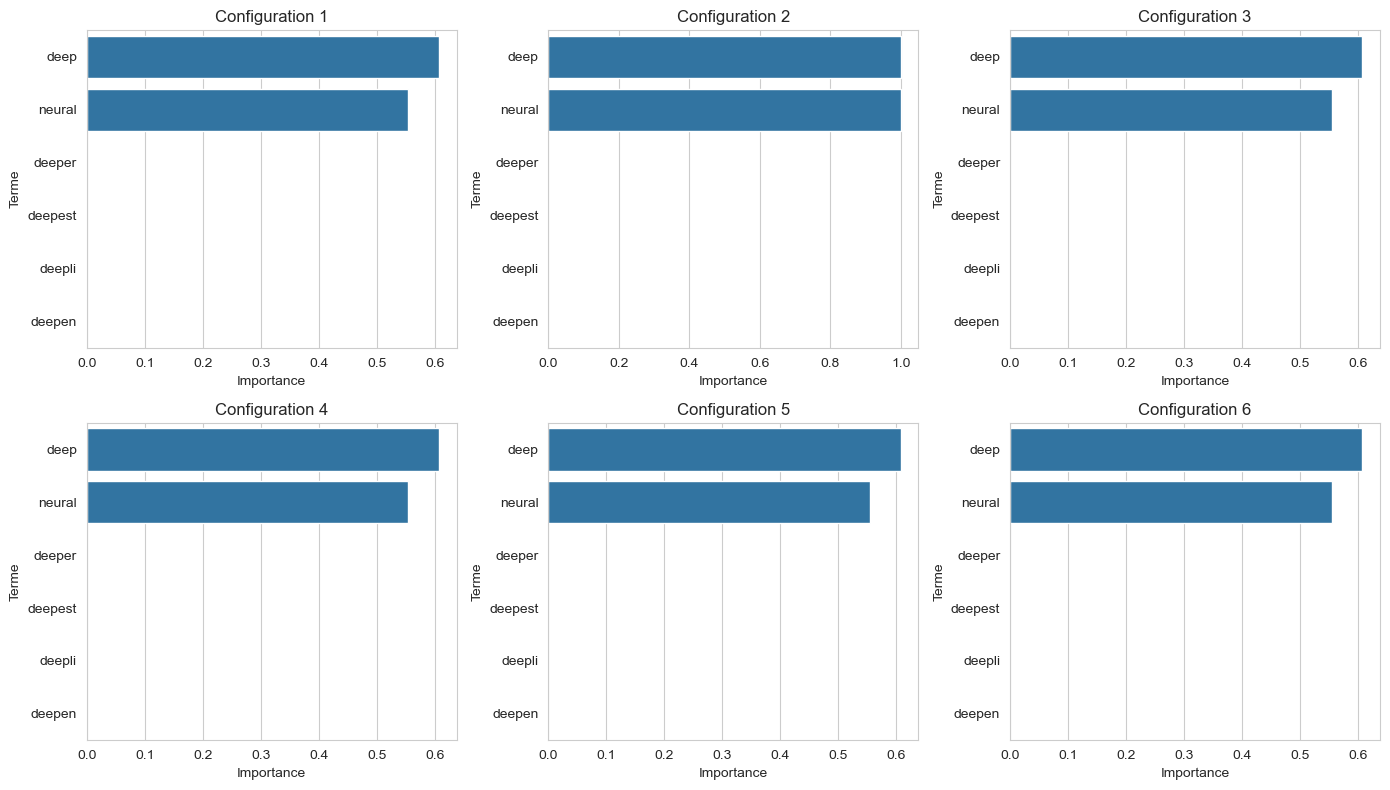

In [8]:
# 6. Comparaison des différentes configurations
# Créez et entraînez différentes variantes du moteur de recherche
variants = create_search_engine_variants()
for variant in variants:
    variant.fit(df)

# Choisissez une requête test
test_query = "deep learning neural networks"

# Comparez les résultats
compare_results = compare_search_results(variants, test_query)

# Visualisez l'importance des termes dans les différentes configurations
visualize_term_importance(variants, test_query)


## Interface interactive

In [ ]:
# 7. Interface interactive
search_interface(engine)


===== MOTEUR DE RECHERCHE D'ARTICLES SCIENTIFIQUES =====
Configuration: TF-IDF, Stemming, sans stopwords, min_df=5, max_df=0.95, similarité=cosine, vocabulaire=Pas de limite

Taille du vocabulaire: 13763
Nombre total d'articles: 79007

Entrez votre requête (ou 'q' pour quitter):
